# Exploring categorical encodings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## Getting data from Kaggle using the API

1. pip install kaggle 
2. read https://www.kaggle.com/docs/api
3. acept the rules https://www.kaggle.com/c/cat-in-the-dat/data
4. kaggle competitions download -c cat-in-the-dat
5. unzip cat-in-the-dat.zip 

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


"The data contains binary features (bin_*), nominal features (nom_*), ordinal features (ord_*) as well as (potentially cyclical) day (of the week) and month features. The string ordinal features ord_{3-5} are lexically ordered according to string.ascii_letters."

In [5]:
df.shape

(300000, 25)

### EDA

In [6]:
Y = df.target.values
X = df.drop(columns=['target'])
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.15, random_state=3)

In [7]:
x_train_val = x_train_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.20, random_state=3)

In [9]:
x_train.shape, x_val.shape, x_test.shape

((204000, 24), (51000, 24), (45000, 24))

In [10]:
x_train.describe()

,id,bin_0,bin_1,bin_2,ord_0,day,month
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000
mean,149926.790049,0.127250,0.256873,0.383990,1.479627,3.004623,5.768137
std,86620.892393,0.333254,0.436910,0.486357,0.712183,1.818179,3.842883
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,74920.250000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000
50%,149987.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000
75%,224881.250000,0.000000,1.000000,1.000000,2.000000,4.000000,9.000000
max,299998.000000,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000


`id` is not useful for prediction

In [11]:
x_train = x_train.drop(columns=['id'])
x_val = x_val.drop(columns=['id'])
x_train_val = x_train_val.drop(columns=['id'])
x_test = x_test.drop(columns=['id'])
x_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
203794,0,0,0,F,N,Green,Triangle,Hamster,Russia,Oboe,...,1440a7319,59aad915a,1,Contributor,Lava Hot,j,U,qP,3,2
76267,0,1,0,T,N,Red,Trapezoid,Lion,Russia,Piano,...,19d1a424d,306e8def6,1,Contributor,Lava Hot,a,A,sD,2,1
232524,0,1,1,T,Y,Green,Trapezoid,Dog,Canada,Piano,...,2912d0fbb,682a405a2,3,Expert,Freezing,i,K,cA,4,4
49073,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Bassoon,...,49cfc8bab,30d1d0cc5,3,Novice,Freezing,a,E,aO,2,12
213004,0,0,0,F,N,Green,Star,Lion,Russia,Piano,...,3032ce76e,bce434c81,1,Contributor,Cold,i,J,Gx,4,12


`bin_0` has 75% quantile 0. Let's look more closely 

In [12]:
np.quantile(x_train.bin_0.values, [0.75, 0.8, 0.85, 0.88, 0.90, 0.99], axis=0)

array([0., 0., 0., 1., 1., 1.])

In [13]:
x_train.bin_0.value_counts()/x_train.shape[0]

0    0.87275
1    0.12725
Name: bin_0, dtype: float64

approx 87% of the data are is 0. I will keep it for now but maybe is not that useful. Let's now look at the target.

In [14]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0, 1]), array([141515,  62485]))

In [15]:
counts/counts.sum()

array([0.69370098, 0.30629902])

30% of the targets are 1s. A little imbalance but not a big deal. We will be using AUC as a metric instead of accuracy.

Now let's look at how many unique values each features has.

In [16]:
{col: len(x_train[col].unique()) for col in x_train.columns}

{'bin_0': 2,
 'bin_1': 2,
 'bin_2': 2,
 'bin_3': 2,
 'bin_4': 2,
 'nom_0': 3,
 'nom_1': 6,
 'nom_2': 6,
 'nom_3': 6,
 'nom_4': 4,
 'nom_5': 222,
 'nom_6': 522,
 'nom_7': 1218,
 'nom_8': 2210,
 'nom_9': 11865,
 'ord_0': 3,
 'ord_1': 5,
 'ord_2': 6,
 'ord_3': 15,
 'ord_4': 26,
 'ord_5': 192,
 'day': 7,
 'month': 12}

Some of these values are large. It it not a big deal for label encoding but I would be for one-hot-encoding.

In [101]:
def plot_multiple_categorical(X, Y, features, top_n=20):
    
    ref = Y.mean() # Reference
    subplots_per_row = 4; landmark = .01
    plt.figure()
    nb_rows = int(np.floor(len(features) / subplots_per_row)) + 1
    fig, ax = plt.subplots(nb_rows, subplots_per_row,
                           figsize=(15, 4.2 * nb_rows))
    plt.subplots_adjust(hspace = .2, wspace = 0.5)
    i = 0; n_row=0; n_col=0
    for feature in features:
        dff = pd.DataFrame({'x': x_train[feature], 'y': y_train})
        tdf = dff.groupby(['x']).agg({'y': ['count', 'mean']})
        tdf = tdf.sort_values(('y', 'count'), ascending=False).head(
            top_n).sort_index()
                  
        tdf.index = tdf.index.map(str)
        ax[n_row, n_col].bar(tdf.index, tdf['y']['mean'].values)
        ax[n_row, n_col].axhline(y=ref, linewidth=3, color='black')
        ax[n_row, n_col].set_title(feature, fontsize=11)
        n_col += 1
        if n_col == subplots_per_row:
            n_col = 0
            n_row += 1

<Figure size 432x288 with 0 Axes>

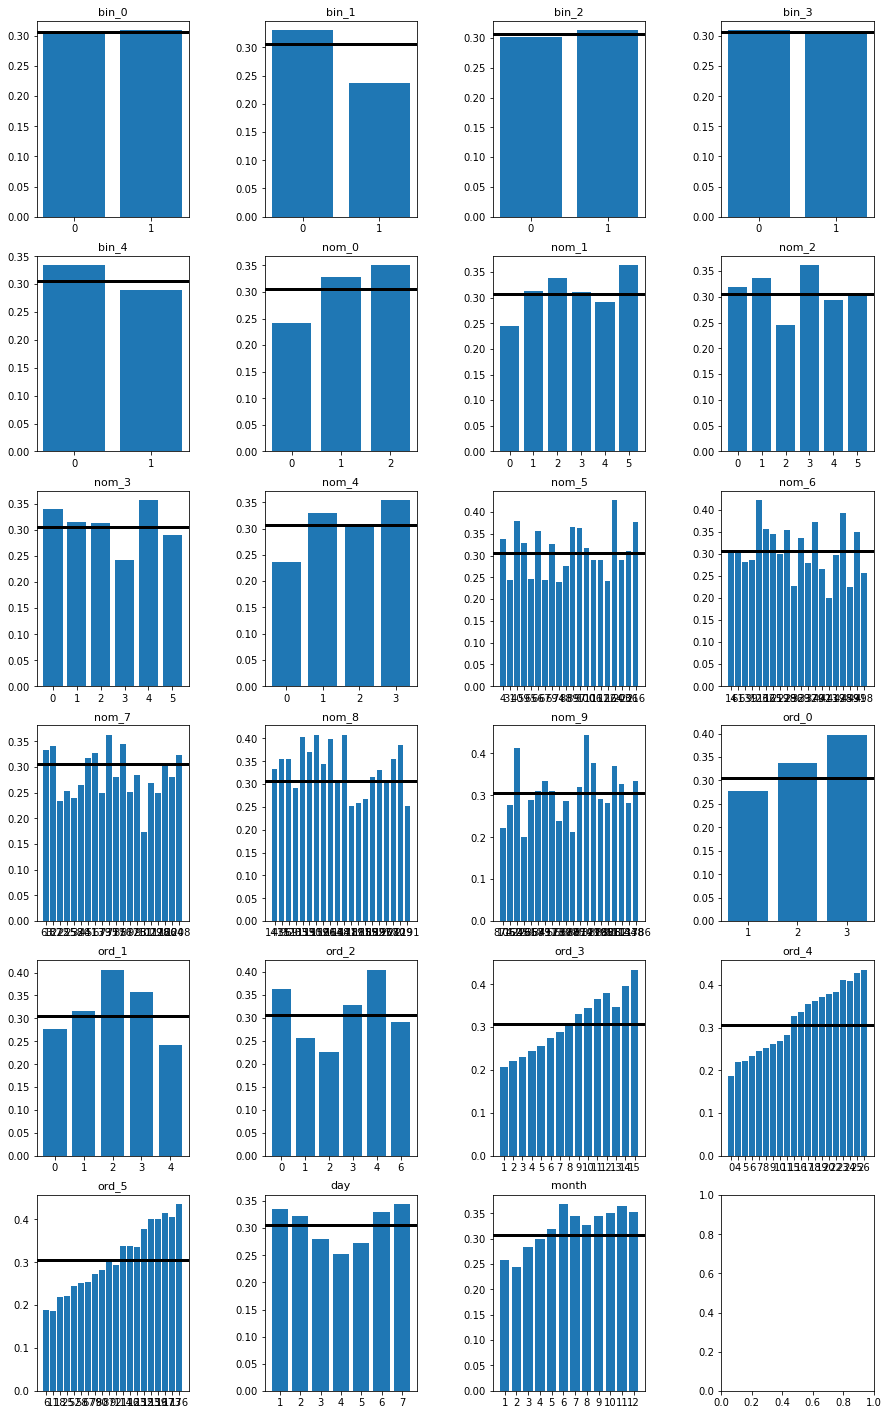

In [102]:
plot_multiple_categorical(x_train, y_train, x_train.columns)

### Solution #1: 
Encode categorical features with label encoding and use a tree based model

In [17]:
from sklearn.preprocessing import LabelEncoder
def label_encoding_with_UNK(col_train, UNK=True):
    """ Returns a label encoding "UNK" values
    """
    le = LabelEncoder()
    uniq = np.unique(col_train)
    if UNK:
        uniq = np.concatenate((np.array(["UNK"]),uniq))
    le.fit(uniq)
    return le

In [18]:
def transform_column(le, index, x_train, x_val, x_train_val, x_test):
    x_train[index] = le.transform(x_train[index])
    val = [x if x in le.classes_ else 'UNK' for x in x_val[index]]
    x_val[index] = le.transform(val)
    train_val =  [x if x in le.classes_ else 'UNK' 
                  for x in x_train_val[index]]
    x_train_val[index] = le.transform(train_val)
    test = [x if x in le.classes_ else 'UNK' for x in x_test[index]]
    x_test[index] = le.transform(test)

In [19]:
le = label_encoding_with_UNK(x_train.nom_0.values)

In [20]:
le.classes_

array(['Blue', 'Green', 'Red', 'UNK'], dtype=object)

In [21]:
le.transform(le.classes_)

array([0, 1, 2, 3])

In [22]:
le.transform(x_train.nom_0.values)

array([1, 2, 1, ..., 1, 0, 0])

In [23]:
# notice a new value 'W' le.transform would break (try it)
fake_nom_0 = np.array(['Blue', 'Green', 'Red', 'W'])

In [24]:
# change "W" for "UNK" and then transform
[x if x in le.classes_ else 'UNK' for x in fake_nom_0]

['Blue', 'Green', 'Red', 'UNK']

In [25]:
# columns that are not numerical already
num_cols = x_train.iloc[:20,].applymap(np.isreal).all(0)

In [26]:
num_cols

bin_0     True
bin_1     True
bin_2     True
bin_3    False
bin_4    False
nom_0    False
nom_1    False
nom_2    False
nom_3    False
nom_4    False
nom_5    False
nom_6    False
nom_7    False
nom_8    False
nom_9    False
ord_0     True
ord_1    False
ord_2    False
ord_3    False
ord_4    False
ord_5    False
day       True
month     True
dtype: bool

In [27]:
for index, value in num_cols.items():
    if not value:
        binary = index.startswith('bin')
        UNK = False if binary else True
        le = label_encoding_with_UNK(x_train[index].values, UNK=UNK)
        transform_column(le, index, x_train, x_val, x_train_val, x_test)

In [28]:
x_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
203794,0,0,0,0,0,1,5,3,5,1,...,180,4143,1,0,4,10,20,159,3,2
76267,0,1,0,1,0,2,4,4,5,2,...,243,2224,1,0,4,1,0,167,2,1
232524,0,1,1,1,1,1,4,2,0,2,...,364,4830,3,1,2,9,10,97,4,4
49073,0,0,0,0,1,0,4,4,5,0,...,619,2242,3,4,2,1,4,90,2,12
213004,0,0,0,0,0,1,3,4,5,2,...,418,8687,1,0,1,9,9,26,4,12


In [238]:
x_test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
29793,0,0,0,0,1,0,4,1,3,1,...,1051,1473,2,4,2,2,26,141,1,4
65074,0,1,0,1,0,0,3,2,1,1,...,2181,5405,2,2,0,8,18,108,3,3
93174,0,0,1,1,0,2,4,4,5,0,...,1886,9584,1,4,4,8,10,26,3,12
150730,0,0,1,0,1,0,2,2,3,2,...,405,10024,2,1,2,7,17,109,2,2
205008,0,0,1,0,0,1,4,2,1,0,...,2067,3078,1,2,0,11,18,7,3,8


### Doing Randomized Search with validation set

In [29]:
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import roc_auc_score

In [30]:
split_index = [-1 if x in x_train.index else 0 for x in x_train_val.index]
pds = PredefinedSplit(test_fold = split_index)

In [31]:
max_depth = [int(x) for x in np.linspace(6, 20, num = 5)]
max_features = [x for x in np.linspace(0.1, 1, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(6, 20, num = 5)]

In [32]:
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [33]:
rf = RandomForestClassifier()

In [34]:
rf_random = RandomizedSearchCV(
    estimator = rf, param_distributions = random_grid, scoring='roc_auc',
    n_iter = 30, cv = pds, random_state=42, verbose=2, n_jobs = -1)

In [35]:
rf_random.fit(x_train_val, y_train_val)

Fitting 1 folds for each of 30 candidates, totalling 30 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
                   estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [6, 9, 13, 16, 20],
                                        'max_features': [0.1, 0.325, 0.55,
                                                         0.775, 1.0],
                                        'min_samples_leaf': [6, 9, 13, 16, 20]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [37]:
roc_auc_score(y_test, rf_random.predict_proba(x_test)[:,1])

0.7457909920415504

In [38]:
importances = rf_random.best_estimator_.feature_importances_

In [39]:
importances

array([0.00381539, 0.02507524, 0.00804034, 0.00826571, 0.01086953,
       0.0356182 , 0.02690999, 0.02274893, 0.02480999, 0.03224892,
       0.04696756, 0.04814144, 0.0484173 , 0.04806176, 0.04872981,
       0.02988853, 0.06621115, 0.06344024, 0.07555627, 0.10806821,
       0.14114568, 0.02661949, 0.05035034])

In [41]:
forest_importances = pd.Series(importances, index=x_train.columns)

In [42]:
forest_importances = forest_importances.sort_values(ascending=False)

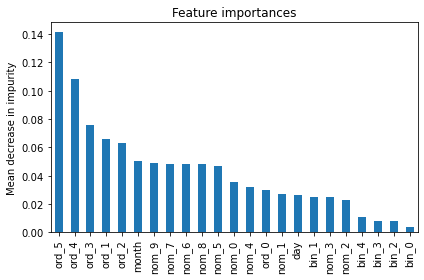

In [43]:
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## References
* https://www.kaggle.com/adaubas/2nd-place-solution-categorical-fe-callenge